In [3]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)  

Already up to date.


In [4]:
# notebook level imports
import random
import dsutils  # regression_confint
import pandas as pd
import seaborn as sns; sns.set_theme()
from sklearn import linear_model       # LinearRegression
from sklearn import tree               # DecisionTreeRegressor
from sklearn import neighbors          # KNeighborsRegressor
from sklearn import neural_network     # MLPRegressor
from sklearn import model_selection    # GridSearchCV



In [5]:
def gen_regression_data(m=2, b=-1, n=50, y_range=30):
   """
   # model parameters!
   m = 2        # slope
   b = -1       # intercept
   # data set specs
   n = 50       # number of points to generate
   y_range = 30 # governs the level of noise on the y coordinate"
   """
   delta_y = \
   pd.Series([random.uniform(-y_range,y_range) for _ in range(n)])

   # generate a dataframe for our data points
   # generate values on the x-axis
   x = pd.DataFrame({'x':[i for i in range(n)]})
   # generate values on the y-axis using x-values
   y = pd.DataFrame({'y': m * x['x'] + b + delta_y})
   # each row represents the point (x,y)
   points_df = pd.concat([x,y], axis=1)
   return points_df

# Regression

* In regression we predict **values** rather than discrete labels.
* In the simplest case we want to fit a line through a set of points - **simple linear regression**.

A straight-line is a model of the form,

$y=mx+b$

where m is the *slope* and b is the *intercept*.  


<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/linreg-scatter.png"  
height="200" 
width="225">

[source](https://towardsdatascience.com/mathematics-hidden-behind-linear-regression-431fe4d11969)





## Example

Let's try this with a synthetic data set.

In [36]:
# n is the number of points to generate
# y_range constrols the level of noise on the y coordinate
points_df = gen_regression_data(n=50, y_range=30) 
points_df.head()  


,x,y
0,0,3.031458
1,1,17.161270
2,2,20.492209
3,3,-23.836357
4,4,-15.209062


<Axes: xlabel='x', ylabel='y'>

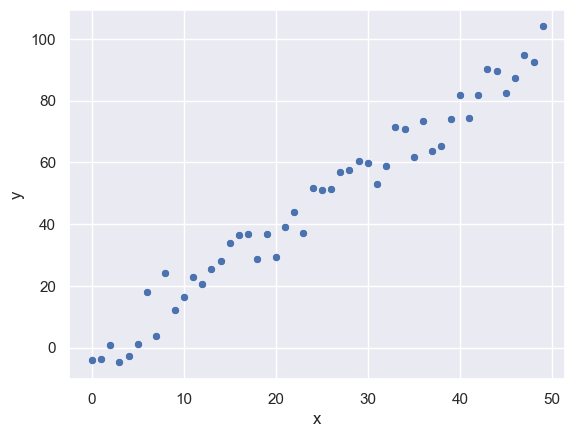

In [31]:

sns.scatterplot(data=points_df, x='x', y='y') 

In [32]:
# regression training data
X = points_df[['x']]
y = points_df['y']

In [33]:

# linear regression model
model = linear_model.LinearRegression()

# fit the model to our noisy data
# x is the independ variable, y the dependent variable
model.fit(X, y)

# print model parameters
print("Slope: {:3.2f}".format(model.coef_[0]))
print("Intercept: {:3.2f}".format(model.intercept_))

Slope: 2.05
Intercept: -3.32


In [34]:
# model performance: the R^2 score
rs = model.score(X,y)
print("R^2 score: {:3.2f}".format(rs))

R^2 score: 0.97


<Axes: xlabel='x', ylabel='y'>

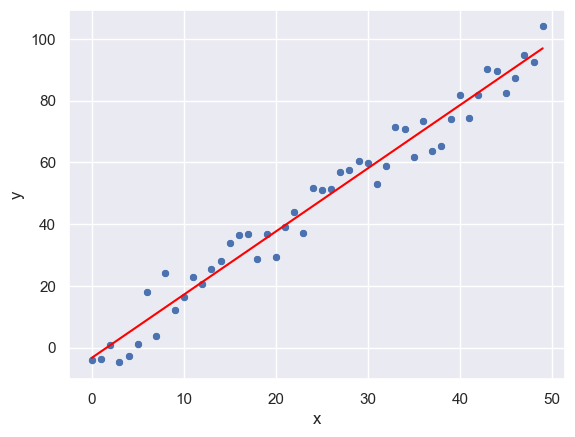

In [35]:

# plot the model together with the data
sns.scatterplot(x=X['x'], y=y)  # data
sns.lineplot(x=X['x'], y=model.predict(X), color='red')  # model

# Another Look at the $R^2$ Score

* The $R^2$ score is a score that compares the errors squared of the regression model to the errors squared of a default model.

* The default model is just the average value $\bar{y}$ of all y-values.  That is, for any x-value the model always returns the same answer: $\bar{y}$.

<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/rs.png" height="400" width="460">

(Source: [Wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination))



## The Mathematics of $R^2$

Let's explore that figure a little bit more assuming that we have a training dataset that consists of the set of points,

$$\{(x_1,y_1), (x_2,y_2),\dots,(x_n,y_n)\}$$

where $x_i$ are the values of the independent variable and $y_i$ are the values of the dependent variable. Then the we have the following definitions,

1. The **default model** is defined as $\bar{y} = \frac{1}{n}\sum_{i=1}^n y_i$, the average of the expected outcomes $y_i$ of the training data.
1. The regression model is $f$ and the **residuals** are defined as $y_i - f(x_i)$ for $i=1\ldots n$, that is, a residual is the difference between the expected outcome $y_i$ at point $x_i$ minus the outcome computed by the model $f(x_i)$.
1. $SS_{\rm res}$ is the squared sum of the residuals of the model $f$, more precisely, $SS_{\rm res} = \sum_{i=1}^n (y_i - f(x_i))^2$.
1. $SS_{\rm tot}$ is the squared sum of the residuals of the default model $\bar{y}$, more precisely, $SS_{\rm tot} = \sum_{i=1}^n (y_i - \bar{y})^2$.

With these definitions we can now compute the $R^2$ score as

$$R^2
= 1 - \frac{SS_{\rm res}}{SS_{\rm tot}}
= 1 - \frac{\sum_{i=1}^n (y_i - f(x_i))^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

Notice that if the performance of our regression model $f$ approaches the performance of our default model $\bar{y}$ then the
score will be,

$$R^2 \approx 1 - 1 = 0$$

If our model $f$ is perfect, that is, all residuals $y_i - f(x_i)$ are equal to zero then we obtain the score,

$$R^2 = 1 - 0 = 1$$

**Conclusions**
* The closer an $R^2$ score is to one the better the model.  
* It turns out that if our model $f$ is worse than the default model $\bar{y}$ then it is possible to obtain negative $R^2$ values.

# Regression Models

Turns out that all the classification models we have covered so far also support regression models:

* Regression Trees (we have seen these before when we discussed non-linear regression)
* KNN Regression Models
* MLP Regression Models

We will use the cars dataset to study these regression models. 

<Axes: xlabel='speed', ylabel='dist'>

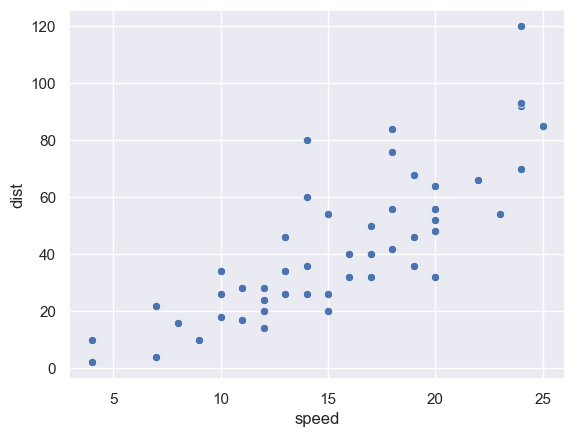

In [37]:
# get our dataset
cars_df = pd.read_csv(home+"cars.csv")
X = cars_df[['speed']]
y = cars_df['dist']

# plot the data
sns.scatterplot(x=X['speed'], y=y)

## Regression Trees

We build a default regression tree.

In [40]:

# regression trees
model = tree.DecisionTreeRegressor().fit(X,y)

<Axes: xlabel='speed', ylabel='dist'>

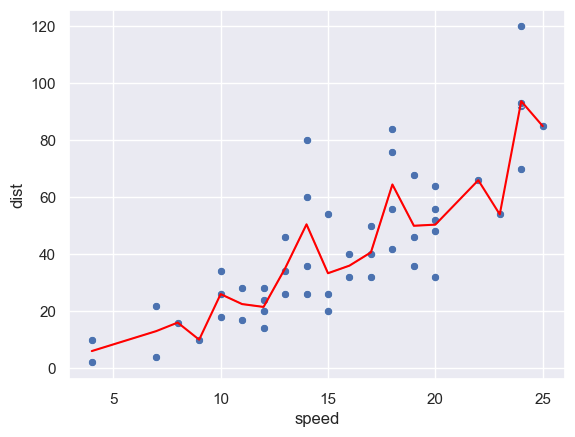

In [41]:
# plot the model
sns.scatterplot(x=X['speed'], y=y)
sns.lineplot(x=X['speed'], y=model.predict(X), color='red') #model

In [42]:
# compute the R^2 score
rs = model.score(X,y)
obs = cars_df.shape[0]
vars = 1
lb, ub = dsutils.regression_confint(rs, obs, vars)
print("R^2 score: {:3.2f} ({:3.2f}, {:3.2f})".format(rs,lb,ub))

R^2 score: 0.79 (0.69, 0.89)


## KNN Regression

* In KNN regression we are not asking the neighbors for a majority label
* Instead we compute the **average value** associated with the neighbors 
* That value becomes the value of the current point in question

Here we build the KNN default regression model.

In [43]:

# KNN regression
model = neighbors.KNeighborsRegressor().fit(X,y)

<Axes: xlabel='speed', ylabel='dist'>

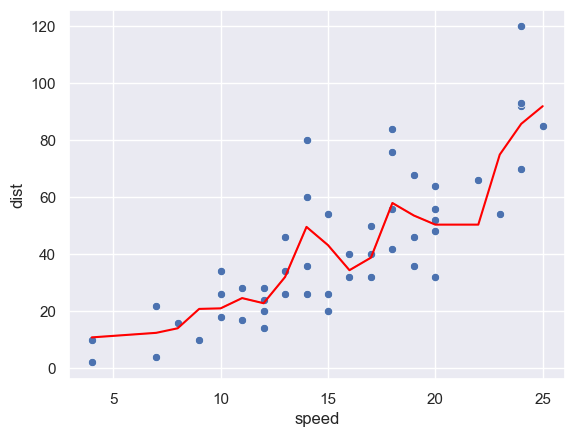

In [44]:
# plot the model
sns.scatterplot(x=X['speed'], y=y)
sns.lineplot(x=X['speed'], y=model.predict(X), color='red') #model

In [45]:

# compute the R^2 score
rs = model.score(X,y)
obs = cars_df.shape[0]
vars = 1
lb, ub = dsutils.regression_confint(rs, obs, vars)
print("R^2 score: {:3.2f} ({:3.2f}, {:3.2f})".format(rs,lb,ub))

R^2 score: 0.74 (0.62, 0.86)


## MLP Regression

* In MLP regression we ask the network to model a continuous value.  
* This turns out to be just a change in interpretation of the output value.  
* Rather than applying a thresholding function to the output like the `sign` function we just use the raw output value as the model output value.

Let's build a ANN regressor using our rule of thumb neural network construction.

In [51]:
# MLP regression model
model = neural_network.MLPRegressor(hidden_layer_sizes=(2,), # rule of thumb architecture
                                    activation='tanh',  # the default activation function does not work well
                                    max_iter=100000)
model.fit(X,y)

MLPRegressor(activation='tanh', hidden_layer_sizes=(2,), max_iter=100000)

<Axes: xlabel='speed', ylabel='dist'>

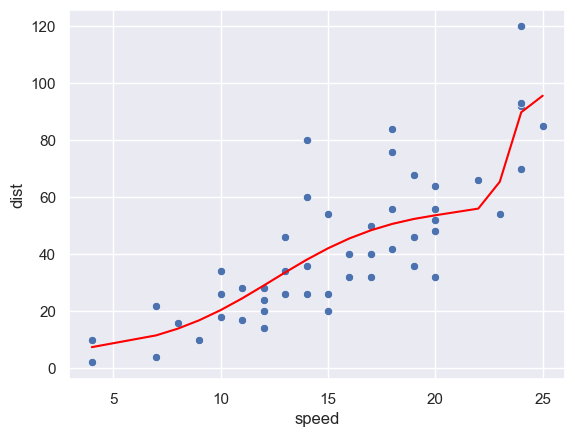

In [52]:
# plot the model
sns.scatterplot(x=X['speed'], y=y)
sns.lineplot(x=X['speed'], y=model.predict(X), color='red') #model

In [ ]:
# compute the R^2 score
rs = model.score(X,y)
obs = cars_df.shape[0]
vars = 1
lb, ub = dsutils.regression_confint(rs, obs, vars)
print("R^2 score: {:3.2f} ({:3.2f}, {:3.2f})".format(rs,lb,ub))

R^2 score: 0.70 (0.57, 0.84)


# Regression and Grid Search: Tree Regression

Just like in classification, regression models are built using a small sample of a possibly infinite data universe and we have to estimate the model parameters for the best model using this small sample. That means we have to perform a grid search over parameter ranges and we want to use cross-validation to minimize the bias of any one particular training-test split of the data.

Let's try this with tree regression. We still use the car data set from the previous section.

In [54]:
# setting up grid search
model = tree.DecisionTreeRegressor()
param_grid = {'max_depth': list(range(1,11))}
grid = model_selection.GridSearchCV(model, param_grid, cv=5)

# performing grid search
grid.fit(cars_df[['speed']], cars_df['dist'])
best_model = grid.best_estimator_

print(grid.best_params_)

{'max_depth': 3}


**Observation**: Interestingly enough, the best regression tree happens to be the tree we used in our raw guess above.

<Axes: xlabel='speed', ylabel='dist'>

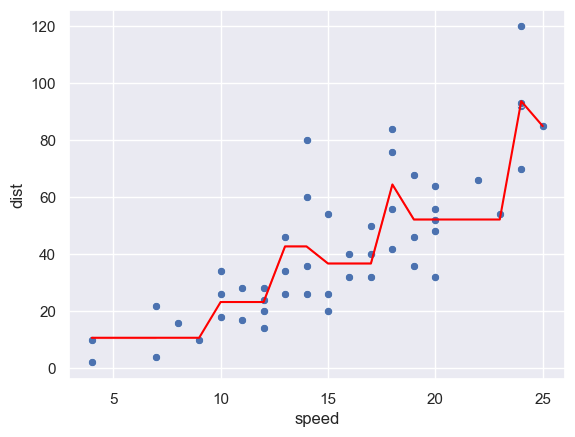

In [56]:
# plot the model
sns.scatterplot(x=X['speed'], y=y)
sns.lineplot(x=X['speed'], y=best_model.predict(X), color='red') #model

In [57]:
# compute the R^2 score
rs = best_model.score(cars_df[['speed']],cars_df['dist'])
obs = cars_df.shape[0]
vars = 1
lb, ub = dsutils.regression_confint(rs, obs, vars)
print("R^2 score: {:3.2f} ({:3.2f}, {:3.2f})".format(rs,lb,ub))

R^2 score: 0.76 (0.66, 0.87)


Hint: Try to do a grid search for k-NN and ANNs.